## 3-D Simulations 

In this notebook, we are doing 3d simulations with gammapy using irfs derrived from one of the HESS observations.   

We will start importing modules and classes!

In [1]:
%matplotlib inline
import numpy as np
import astropy.units as u
from regions import CircleSkyRegion
import matplotlib.pyplot as plt
from scipy.stats import norm
from astropy.coordinates import SkyCoord
from gammapy.irf import load_cta_irfs
from gammapy.maps import WcsGeom, MapAxis, Map
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    GaussianSpatialModel,
    SkyModel,
    Models,
    FoVBackgroundModel,
)

from gammapy.makers import (
    RingBackgroundMaker, SafeMaskMaker,
    MapDatasetMaker
)

from gammapy.modeling import Fit
from gammapy.data import Observation
from gammapy.datasets import MapDataset

from gammapy.datasets import (
    Datasets,
    FluxPointsDataset,
    SpectrumDataset,
    MapDataset,
    MapDatasetOnOff,
)

from gammapy.estimators import ExcessMapEstimator

from gammapy.irf.background import Background3D
from gammapy.irf.effective_area import EffectiveAreaTable2D
from gammapy.irf.energy_dispersion import EnergyDispersion2D
from gammapy.irf.psf_gauss import EnergyDependentMultiGaussPSF
from gammapy.irf.psf_table import EnergyDependentTablePSF
from gammapy.irf.psf_3d import PSF3D

In [2]:
aeff_filename = './irfs/hess_aeff_2d_152901.fits.gz'
bkg_filename  = './irfs/hess_bkg_3d_v05c_fov_radec_152901.fits.gz'
edisp_filename = './irfs/hess_edisp_2d_152901.fits.gz'
psf_filename   = './irfs/hess_psf_table_152901.fits.gz'

# Loading IRFs
def load_hess_irfs(aeff_filename, bkg_filename, edisp_filename, psf_filename):
    aeff = EffectiveAreaTable2D.read(aeff_filename, hdu="EFFECTIVE AREA")
    bkg = Background3D.read(bkg_filename, hdu="BACKGROUND")
    edisp = EnergyDispersion2D.read(edisp_filename, hdu="EDISP_2D")
    psf = PSF3D.read(psf_filename, hdu="PSF_2D_TABLE")
    
    return dict(aeff=aeff, bkg=bkg, edisp=edisp, psf=psf)

In [3]:
hess_irfs = load_hess_irfs(aeff_filename, bkg_filename, edisp_filename, psf_filename)

We define the livetime for a single observations (~28mins per observations). The pointing position is exactely simular to the grb 190829A position.

In [4]:
# Define the observation parameters 
#(typically the observation duration and the pointing position):

livetime = 0.46 * u.hr
pointing = SkyCoord(44.544, -8.958, unit="deg", frame="icrs")

We define the Geometry of the binned simulations: 

In [5]:
# Define map geometry for binned simulation
energy_axis = MapAxis.from_energy_bounds("0.1 TeV", "200 TeV", nbin=5, per_decade=True)


# It is usually useful to have a separate binning for the true energy axis
energy_axis_true = MapAxis.from_energy_bounds("0.1 TeV", "200 TeV", nbin=5, per_decade=True, name="energy_true")


geom = WcsGeom.create(
    skydir=(44.544, -8.958),
    binsz=0.02,
    width=(3, 3),
    frame="icrs",
    axes=[energy_axis],
)

In [6]:
empty = MapDataset.create(geom, energy_axis_true=energy_axis_true, name="dataset-simu") # stacked for many_obs

maker = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"])

maker_safe_mask = SafeMaskMaker(methods=["offset-max"], offset_max=3.5 * u.deg)


Create the exclusion mask 

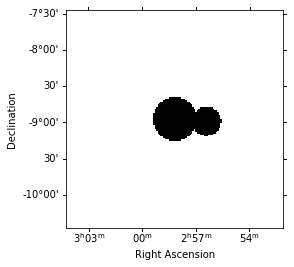

In [7]:
# get the geom that we use
geom_image = geom.to_image().to_cube([energy_axis.squash()])

## Define the near by gamma-ray emitter to exclude!
star_ra= 44.106
star_dec= -8.98981

star_pos = SkyCoord( star_ra, star_dec, unit="deg", frame="icrs")
# Make the exclusion mask
regions1 = CircleSkyRegion(center=pointing, radius=0.3 * u.deg)
regions2 = CircleSkyRegion(center = star_pos, radius=0.2*u.deg)
exclusion_mask = Map.from_geom(geom_image)
exclusion_mask.data = geom_image.region_mask([regions1, regions2], inside=False)
#exclusion_mask = Map.from_geom(geom, data=geom.region_mask([regions1, regions2], inside=False))
exclusion_mask.sum_over_axes().plot();

Creating the ring to be used for the ring bkg modeling!

In [8]:
ring_maker = RingBackgroundMaker(
    r_in="0.3 deg", width="0.3 deg", exclusion_mask=exclusion_mask)

Next we create an in memory observations and we use that for simulation!

In [9]:
# Create an in-memory observation
obs = Observation.create(pointing=pointing, livetime=livetime, irfs=hess_irfs)
print(obs)

Observation

	obs id            : 0 
 	tstart            : 51544.00
	tstop             : 51544.02
	duration          : 1656.00 s
	pointing (icrs)   : 44.5 deg, -9.0 deg

	deadtime fraction : 0.0%



#### Start Data reduction

In [10]:
%%time
dataset = maker.run(empty, obs)
dataset = maker_safe_mask.run(dataset, obs)
print(dataset)

MapDataset
----------

  Name                            : dataset-simu 

  Total counts                    : nan 
  Total background counts         : 2362.62
  Total excess counts             : nan

  Predicted counts                : 2362.62
  Predicted background counts     : 2362.62
  Predicted excess counts         : nan

  Exposure min                    : 4.86e+04 m2 s
  Exposure max                    : 7.26e+08 m2 s

  Number of total bins            : 0 
  Number of fit bins              : 382500 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


CPU times: user 521 ms, sys: 95.2 ms, total: 616 ms
Wall time: 616 ms


Here we define the sky model used to simulate the data. In this case, I use a gaussian spacial model and a power low spectral model. 

In [11]:
spatial_model = GaussianSpatialModel(
    lon_0="44.544 deg", lat_0="-8.958 deg", sigma="0.03 deg", frame="icrs"
)
spectral_model = PowerLawSpectralModel(
    index=2.5, amplitude="1.4e-11 cm-2 s-1 TeV-1", reference="0.55 TeV"
)
model_simu = SkyModel(
    spatial_model=spatial_model,
    spectral_model=spectral_model,
    name="model-simu",
)

bkg_model = FoVBackgroundModel(dataset_name="dataset-simu")

models = Models([model_simu, bkg_model])
print(models)

Models

Component 0: SkyModel

  Name                      : model-simu
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    index                   :   2.500              
    amplitude               :   1.40e-11  1 / (cm2 s TeV)
    reference    (frozen)   :   0.550  TeV         
    lon_0                   :  44.544  deg         
    lat_0                   :  -8.958  deg         
    sigma                   :   0.030  deg         
    e            (frozen)   :   0.000              
    phi          (frozen)   :   0.000  deg         

Component 1: FoVBackgroundModel

  Name                      : dataset-simu-bkg
  Datasets names            : ['dataset-simu']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    norm                    :   1.000              
    tilt         (frozen)   :   0.000              
    reference    (fro

We now add the model to the actual dataset:

In [12]:
# Add the model on the dataset and Poission fluctuate
dataset.models = models


Next, we fake poisons distributed events using gammapy.fake() class

In [13]:
dataset.fake()

# Do a print on the dataset - there is now a counts maps
print(dataset)

MapDataset
----------

  Name                            : dataset-simu 

  Total counts                    : 2441 
  Total background counts         : 2362.62
  Total excess counts             : 78.38

  Predicted counts                : 2410.09
  Predicted background counts     : 2362.62
  Predicted excess counts         : 47.47

  Exposure min                    : 4.86e+04 m2 s
  Exposure max                    : 7.26e+08 m2 s

  Number of total bins            : 382500 
  Number of fit bins              : 382500 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 23321.45

  Number of models                : 2 
  Number of parameters            : 11
  Number of free parameters       : 6

  Component 0: SkyModel
  
    Name                      : model-simu
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal model type       : 
    Parameters:
      ind

And finaly we create an ON and OFF datasets using ring bkg:

In [14]:
dataset_on_off = ring_maker.run(dataset, )


In [15]:
print(dataset_on_off)

MapDatasetOnOff
---------------

  Name                            : dataset-simu 

  Total counts                    : 2441 
  Total background counts         : 2390.95
  Total excess counts             : 50.05

  Predicted counts                : 2390.98
  Predicted background counts     : 2390.98
  Predicted excess counts         : nan

  Exposure min                    : 4.86e+04 m2 s
  Exposure max                    : 7.26e+08 m2 s

  Number of total bins            : 382500 
  Number of fit bins              : 382500 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 18458.41

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 4023303 
  Acceptance                      : 2363 
  Acceptance off                  : 3978160 



### Estimating a multiple of maps

In [16]:
# Using a convolution radius of 0.04 degrees
estimator = ExcessMapEstimator(0.05 * u.deg, selection_optional=[])
lima_maps = estimator.run(dataset_on_off)

:Reading all maps

In [17]:
significance_map = lima_maps["sqrt_ts"]
excess_map = lima_maps["excess"]

background_map = lima_maps['background']
on_counts_map = lima_maps['counts']
TS_map = lima_maps['ts']
Flux_map = lima_maps['flux']

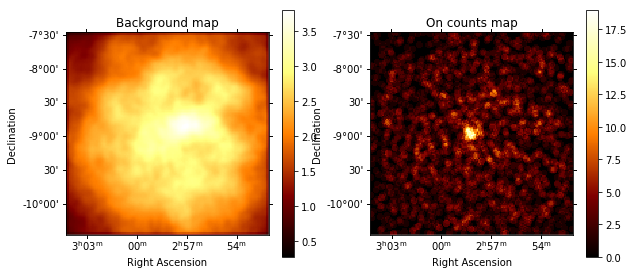

In [18]:
# We can plot the excess and significance maps
plt.figure(figsize=(10, 10))
ax1 = plt.subplot(221, projection=background_map.geom.wcs)
ax2 = plt.subplot(222, projection=on_counts_map.geom.wcs)

bkg = ax1.set_title("Background map")
bkg = background_map.plot(ax=ax1, add_cbar=True)

on = ax2.set_title("On counts map")
on = on_counts_map.plot(ax=ax2, add_cbar=True)

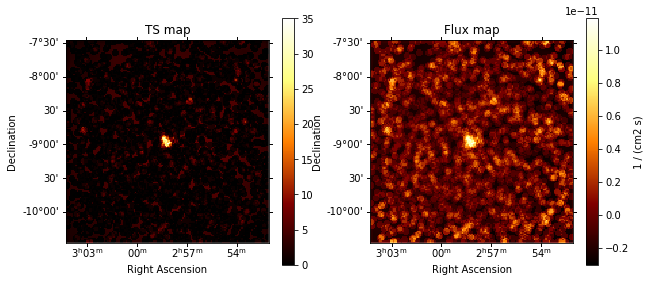

In [19]:
# We can plot the excess and significance maps
plt.figure(figsize=(10, 10))
ax1 = plt.subplot(221, projection=TS_map.geom.wcs)
ax2 = plt.subplot(222, projection=Flux_map.geom.wcs)
#ax3 = plt.subplot(223, projection=upperlimit_map.geom.wcs)


ts = ax1.set_title("TS map")
ts = TS_map.plot(ax=ax1, add_cbar=True)

fl = ax2.set_title("Flux map")
fl = Flux_map.plot(ax=ax2, add_cbar=True)


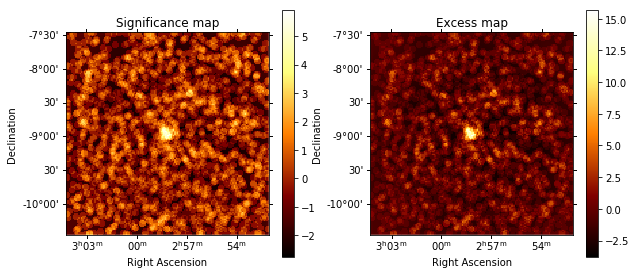

In [20]:
# We can plot the excess and significance maps
plt.figure(figsize=(10, 10))
ax1 = plt.subplot(221, projection=significance_map.geom.wcs)
ax2 = plt.subplot(222, projection=excess_map.geom.wcs)

s = ax1.set_title("Significance map")
s = significance_map.plot(ax=ax1, add_cbar=True)

e = ax2.set_title("Excess map")
e = excess_map.plot(ax=ax2, add_cbar=True)

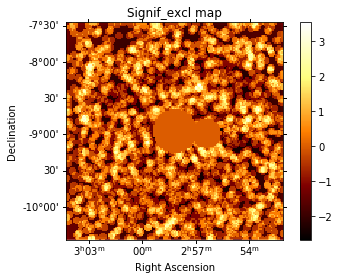

In [21]:
Signif_exclusion = significance_map * exclusion_mask # significance_map_off
ax1 = plt.subplot(111, projection=Signif_exclusion.geom.wcs)
exl = ax1.set_title("Signif_excl map")
exl = Signif_exclusion.plot(ax=ax1, add_cbar=True)

Fit results: mu = -0.13, std = 1.04


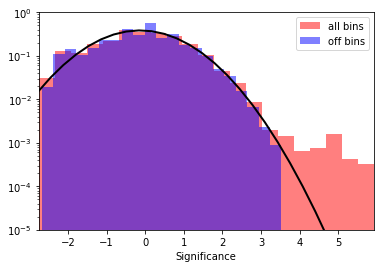

In [22]:
# create a 2D mask for the images
significance_map_off = significance_map * exclusion_mask
significance_all = significance_map.data[np.isfinite(significance_map.data)]
significance_off = significance_map_off.data[
    np.isfinite(significance_map_off.data)
]

plt.hist(
    significance_all,
    density=True,
    alpha=0.5,
    color="red",
    label="all bins",
    bins=21,
)

plt.hist(
    significance_off,
    density=True,
    alpha=0.5,
    color="blue",
    label="off bins",
    bins=21,
)

# Now, fit the off distribution with a Gaussian
mu, std = norm.fit(significance_off)
x = np.linspace(-8, 8, 50)
p = norm.pdf(x, mu, std)
plt.plot(x, p, lw=2, color="black")
plt.legend()
plt.xlabel("Significance")
plt.yscale("log")
plt.ylim(1e-5, 1)
xmin, xmax = np.min(significance_all), np.max(significance_all)
plt.xlim(xmin, xmax)

print(f"Fit results: mu = {mu:.2f}, std = {std:.2f}")

## Simulating 4 hrs of observations

Now we are goining to make a stacked dataset

In [23]:
stacked_on_off = MapDatasetOnOff.create(
    geom=geom_image, energy_axis_true=energy_axis_true, name="stacked_simu"
)

In [24]:
%%time

n_obs = 8


for idx in range(n_obs):
    dataset.fake(
        random_state=idx,  )
    dataset_fake = dataset.copy(name=f"obs-{idx}")
    dataset_fake.meta_table["OBS_ID"] = [idx]
    dataset_on_off = ring_maker.run(dataset_fake.to_image())
    stacked_on_off.stack(dataset_on_off)

/Users/jean/opt/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:481: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


CPU times: user 758 ms, sys: 86.2 ms, total: 844 ms
Wall time: 846 ms


In [25]:
print(stacked_on_off)

MapDatasetOnOff
---------------

  Name                            : stacked_simu 

  Total counts                    : 19335 
  Total background counts         : 18995.63
  Total excess counts             : 339.37

  Predicted counts                : 18995.84
  Predicted background counts     : 18995.84
  Predicted excess counts         : nan

  Exposure min                    : 3.89e+05 m2 s
  Exposure max                    : 5.81e+09 m2 s

  Number of total bins            : 22500 
  Number of fit bins              : 22500 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 25581.31

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 31979598 
  Acceptance                      : 22500 
  Acceptance off                  : 37182569 



/Users/jean/opt/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:481: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Therefore,  the estimated excess counts and map can be produced: 

In [26]:
# Using a convolution radius of 0.04 degrees
estimator = ExcessMapEstimator(0.05 * u.deg, selection_optional=[])
lima_maps = estimator.run(stacked_on_off)

In [27]:
significance_map = lima_maps["sqrt_ts"]
excess_map = lima_maps["excess"]

background_map = lima_maps['background']
on_counts_map = lima_maps['counts']
TS_map = lima_maps['ts']
Flux_map = lima_maps['flux']

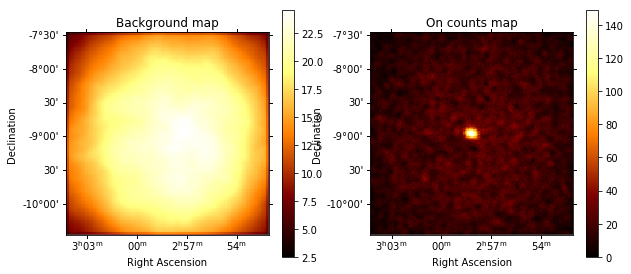

In [28]:
# We can plot the excess and significance maps
plt.figure(figsize=(10, 10))
ax1 = plt.subplot(221, projection=background_map.geom.wcs)
ax2 = plt.subplot(222, projection=on_counts_map.geom.wcs)

b = ax1.set_title("Background map")
b = background_map.plot(ax=ax1, add_cbar=True)

o = ax2.set_title("On counts map")
o = on_counts_map.plot(ax=ax2, add_cbar=True)

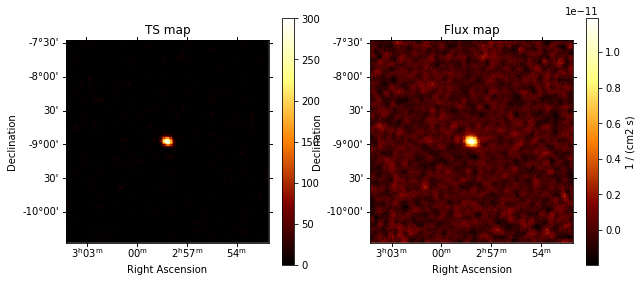

In [29]:
# We can plot the excess and significance maps
plt.figure(figsize=(10, 10))
ax1 = plt.subplot(221, projection=TS_map.geom.wcs)
ax2 = plt.subplot(222, projection=Flux_map.geom.wcs)
#ax3 = plt.subplot(223, projection=upperlimit_map.geom.wcs)


t = ax1.set_title("TS map")
t = TS_map.plot(ax=ax1, add_cbar=True)

f = ax2.set_title("Flux map")
f = Flux_map.plot(ax=ax2, add_cbar=True)


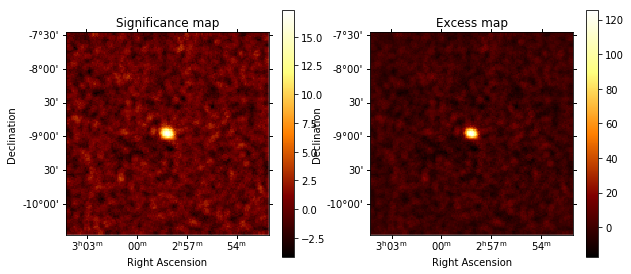

In [30]:
# We can plot the excess and significance maps
plt.figure(figsize=(10, 10))
ax1 = plt.subplot(221, projection=significance_map.geom.wcs)
ax2 = plt.subplot(222, projection=excess_map.geom.wcs)

s = ax1.set_title("Significance map")
s = significance_map.plot(ax=ax1, add_cbar=True)

e = ax2.set_title("Excess map")
e = excess_map.plot(ax=ax2, add_cbar=True)

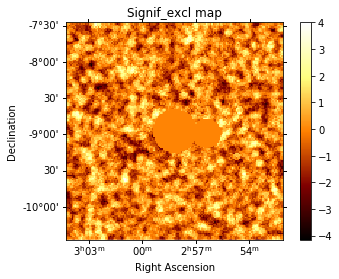

In [31]:
Signif_exclusion = significance_map * exclusion_mask # significance_map_off
ax1 = plt.subplot(111, projection=Signif_exclusion.geom.wcs)
axl = ax1.set_title("Signif_excl map")
axl = Signif_exclusion.plot(ax=ax1, add_cbar=True)

Fit results: mu = -0.04, std = 0.98


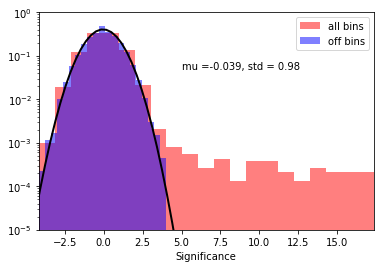

In [32]:
# create a 2D mask for the images
significance_map_off = significance_map * exclusion_mask
significance_all = significance_map.data[np.isfinite(significance_map.data)]
significance_off = significance_map_off.data[
    np.isfinite(significance_map_off.data)
]

plt.hist(
    significance_all,
    density=True,
    alpha=0.5,
    color="red",
    label="all bins",
    bins=21,
)

plt.hist(
    significance_off,
    density=True,
    alpha=0.5,
    color="blue",
    label="off bins",
    bins=21,
)

# Now, fit the off distribution with a Gaussian
mu, std = norm.fit(significance_off)
x = np.linspace(-8, 8, 50)
p = norm.pdf(x, mu, std)
plt.plot(x, p, lw=2, color="black")
plt.legend()
plt.xlabel("Significance")
plt.yscale("log")
plt.ylim(1e-5, 1)
xmin, xmax = np.min(significance_all), np.max(significance_all)
plt.xlim(xmin, xmax)
plt.text(5, 0.05, f'mu ={mu:0.2}, std = {std:.2}')
print(f"Fit results: mu = {mu:.2f}, std = {std:.2f}")